<a href="https://colab.research.google.com/github/AmazingAryan/Digit-Recogniser/blob/main/DigiRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T090602Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db284c73bfd4a72db543ebad1e74b0767468f4751e028118f626eedeb2765bf5171e4ab79325281c0ac0065729ff55f25cfd615e46f252b8c91dd1d9d9d878ee144e31f4fd177f8c1c235cbecd965ff864fd20957ef145b029d8b43b4800a93a5e735223a3e711ce8daadc5f6c5bd1ac71d74cc84d7725e6ed637213619793b2481b3dae97d0e61e9a2431662453daf57eab96ee45c02e5bdd152bbf62f636924fe25026e4fcae17e348ac69efd4055817aa98413f4edf70785baf72742f6f127366ddba2f46f2f03186b4cb1c1365c49cfce81f6e8d306343ea6ea657a347e2be7c1760d60026a1fdef9813f91c9c8ffc8076a04e326d0a4734fcb09a1aa6419'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [5]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape


In [7]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2



In [8]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [9]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[7 7 5 ... 1 5 5] [5 2 8 ... 0 9 0]
0.1204390243902439
Iteration:  10
[3 3 8 ... 1 2 0] [5 2 8 ... 0 9 0]
0.13670731707317074
Iteration:  20
[3 3 8 ... 9 3 3] [5 2 8 ... 0 9 0]
0.18297560975609756
Iteration:  30
[7 3 8 ... 3 3 3] [5 2 8 ... 0 9 0]
0.21870731707317073
Iteration:  40
[7 3 8 ... 3 2 3] [5 2 8 ... 0 9 0]
0.2715609756097561
Iteration:  50
[7 3 8 ... 3 2 3] [5 2 8 ... 0 9 0]
0.33263414634146343
Iteration:  60
[7 3 8 ... 3 6 0] [5 2 8 ... 0 9 0]
0.3936829268292683
Iteration:  70
[7 2 8 ... 3 9 0] [5 2 8 ... 0 9 0]
0.43953658536585366
Iteration:  80
[1 2 8 ... 3 9 0] [5 2 8 ... 0 9 0]
0.48178048780487803
Iteration:  90
[1 2 5 ... 0 9 0] [5 2 8 ... 0 9 0]
0.5204634146341464
Iteration:  100
[1 2 5 ... 0 9 0] [5 2 8 ... 0 9 0]
0.5543658536585366
Iteration:  110
[1 2 5 ... 0 9 0] [5 2 8 ... 0 9 0]
0.5828536585365853
Iteration:  120
[1 2 5 ... 0 9 0] [5 2 8 ... 0 9 0]
0.6067560975609756
Iteration:  130
[2 2 5 ... 0 9 0] [5 2 8 ... 0 9 0]
0.6275121951219512
Iteration: 

In [10]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [11]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[1 9 7 7 6 3 7 0 9 9 8 0 8 1 8 3 2 5 9 3 5 9 7 9 8 3 6 1 6 5 4 3 5 6 2 0 0
 2 0 0 4 4 7 4 4 5 1 6 1 2 8 9 2 3 7 5 5 2 7 5 1 0 8 3 6 2 7 7 1 1 0 3 8 9
 7 5 7 3 4 7 4 2 5 0 7 4 6 8 1 5 6 0 2 9 4 5 2 1 8 2 2 6 6 8 2 6 4 6 9 4 7
 8 7 9 0 8 4 3 3 4 3 0 0 9 1 6 2 1 3 1 9 3 4 4 4 0 3 3 9 9 0 1 1 1 4 4 5 0
 2 3 2 3 0 1 1 2 6 1 4 2 2 5 6 3 9 1 1 1 7 3 6 5 6 2 9 0 3 6 6 7 9 8 7 7 6
 2 3 4 9 0 7 2 8 3 4 8 9 6 1 9 2 1 5 6 8 1 1 2 5 5 0 5 1 1 9 3 0 1 9 9 8 0
 6 0 7 1 3 4 0 8 0 9 2 2 4 3 4 6 5 0 9 8 0 9 2 0 8 4 8 7 9 1 0 6 1 7 9 1 1
 1 8 2 2 2 3 1 2 1 8 2 6 8 8 0 3 1 7 8 9 9 2 2 9 8 5 3 6 4 7 7 6 5 3 8 6 0
 7 2 8 9 8 4 7 8 7 3 2 0 9 9 1 6 1 7 6 9 8 9 6 6 4 1 6 7 1 2 0 1 1 6 0 3 5
 2 2 7 5 1 7 8 9 3 6 5 3 1 1 3 1 4 9 7 9 5 1 4 5 1 8 6 8 1 4 7 5 0 4 5 3 9
 7 3 7 2 8 6 0 0 6 2 6 2 6 2 8 8 7 0 6 2 9 7 8 0 2 1 1 2 2 9 3 7 5 1 4 3 7
 9 1 9 8 1 5 3 8 9 9 2 0 6 1 1 8 9 9 5 6 2 9 9 1 9 1 7 2 8 6 7 1 0 4 7 7 9
 8 0 1 8 5 4 7 3 0 4 7 5 3 3 4 4 1 5 9 9 2 4 9 0 7 8 1 2 0 6 3 3 5 1 5 3 2
 5 3 5 3 8 8 1 0 4 5 2 4 

0.835

Prediction:  [5]
Label:  5


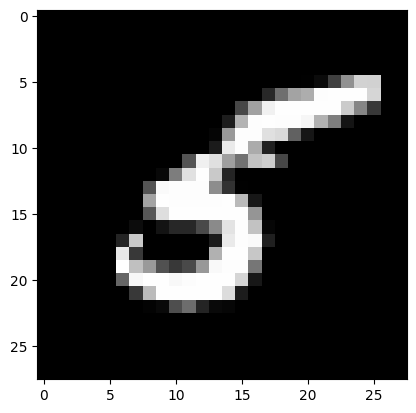

In [12]:
test_prediction(0, W1, b1, W2, b2)

Prediction:  [2]
Label:  2


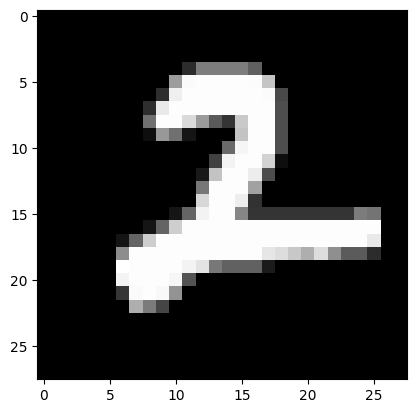

Prediction:  [8]
Label:  8


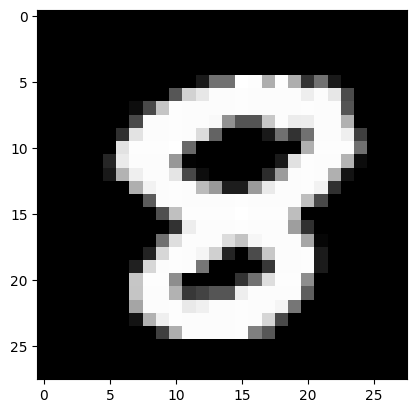

Prediction:  [4]
Label:  4


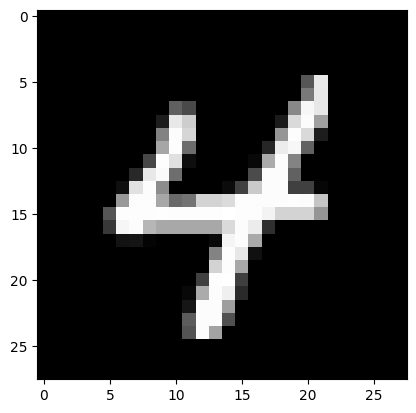

In [13]:
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)